<a href="https://colab.research.google.com/github/Shahid1993/pytorch-notebooks/blob/master/01_First_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Based on [Deep Learning 101 — Building your first Neural Network with PyTorch](https://medium.com/analytics-vidhya/deep-learning-101-building-your-first-neural-network-with-pytorch-39d2709dce32)

# [Installation on Ubuntu](https://www.liquidweb.com/kb/how-to-install-pytorch-on-ubuntu/)

Update Conda Env:
---
`conda update -n base -c defaults conda`

Install PyTorch using conda :
---
`conda install pytorch torchvision cpuonly -c pytorch`


#Imports

In [0]:
import numpy as np
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
%matplotlib inline

#Data Prep

In [0]:
np.random.seed(0)
torch.manual_seed(0)

X, y = make_moons(500, noise=0.2)

# Split into test and training data
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.25, random_state=73)

# Plot

**Neural Networks are non-linear function approximators.**

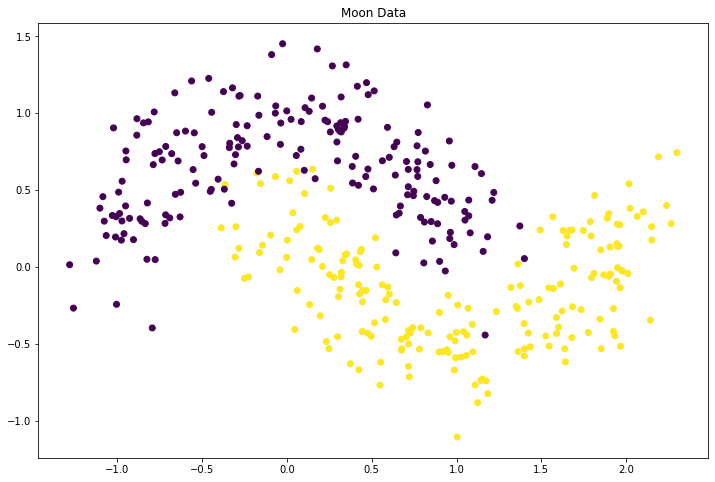

In [14]:
plt.figure(figsize=(12, 8))
plt.scatter(X_train[:,0], X_train[:,1], c=y_train)
plt.title('Moon Data')
plt.show()

#Build our Neural Network

PyTorch networks are really quick and easy to build, just set up the inputs and outputs as needed, then stack your linear layers together with a non-linear activation function in between. At the end of it, you’ll be able to simply print your network for visual inspection.



In [15]:
# Define network dimensions
n_input_dimensions = X_train.shape[1]

# Layer Size
n_hidden = 4 # No. of hidden nodes
n_output = 1 # No. of output nodes = for binary classifier

# Build your classifer
net = nn.Sequential(
    nn.Linear(n_input_dimensions, n_hidden),
    nn.ELU(),
    nn.Linear(n_hidden, n_output),
    nn.Sigmoid()
)

print(net)

Sequential(
  (0): Linear(in_features=2, out_features=4, bias=True)
  (1): ELU(alpha=1.0)
  (2): Linear(in_features=4, out_features=1, bias=True)
  (3): Sigmoid()
)


**Note :**
The network itself takes inputs to produce a given output, there are no special methods that need to be called or any other steps in order to complete a forward pass. For example:

In [16]:
x = torch.FloatTensor([1, 1])
net(x)  

tensor([0.5764], grad_fn=<SigmoidBackward>)

**Note :** we can run this on a GPU if we have CUDA installed with a rather simple adjustment.

In [0]:
# net.cuda()
# x = torch.FloatTensor([1, 1]).to(device='cuda')
# net(x)

## Define Loss Function and Optimizer
Thanks to the wonders of **auto differentiation**, we can let PyTorch handle all of the derivatives and messy details of back-propagation making our training seamless and straightforward.

In [0]:
loss_func = nn.BCELoss()
learning_rate = 0.01
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

#Training a Binary Classifier
- PyTorch doesn’t take Numpy arrays directly, so we’ll need to pass those values through the `torch.FloatTensor` function first to convert it to the proper format
- If you want to run this on your GPU, just add `.to(device='cuda')` to the end of each of these commands and send the network to the GPU as done above too
- Once we've made our predictions and calculated our loss, we need to call the `.backward()` method on the `loss` tensor itself. This tells PyTorch to calculate all of the gradients for our network.
- After that, we tell the optimizer to `.step()` forward, which applies those gradients to all of the weights and biases in the network, causing it to learn the data better.
- After that, we can zero out all of the gradients, essentially throwing them away so that we can apply the new gradients after the next iteration.
- To log our data, you'll notice we call the `.detach()` method on our predictions, `y_hat`. We do this to tell PyTorch to remove the graph structure from this value meaning that we no longer want to calculate derivatives with these values. It's very important to keep track of what are variables with gradients and which ones aren't, particularly if you have multiple networks working together.

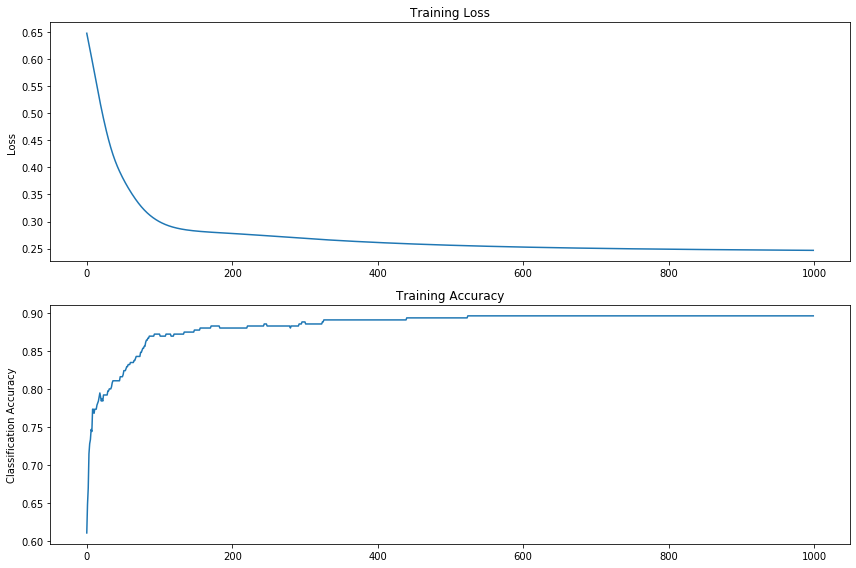

In [19]:
train_loss = []
train_accuracy = []
iters = 1000

y_train_t = torch.FloatTensor(y_train).reshape(-1, 1)

for i in range(iters):
  X_train_t = torch.FloatTensor(X_train)
  y_hat = net(X_train_t)
  loss = loss_func(y_hat, y_train_t)
  loss.backward()
  optimizer.step()
  optimizer.zero_grad()
  y_hat_class = np.where(y_hat.detach().numpy() < 0.5, 0, 1)
  accuracy = np.sum(y_train.reshape(-1, 1) == y_hat_class) / len(y_train)

  train_accuracy.append(accuracy)
  train_loss.append(loss.item())

fig, ax = plt.subplots(2, 1, figsize=(12,8))

ax[0].plot(train_loss)
ax[0].set_ylabel('Loss')
ax[0].set_title('Training Loss')


ax[1].plot(train_accuracy)
ax[1].set_ylabel('Classification Accuracy')
ax[1].set_title('Training Accuracy')

plt.tight_layout()
plt.show()


# Check Accuracy on Test set

In [20]:
# Pass test data
X_test_t = torch.FloatTensor(X_test)
y_hat_test = net(X_test_t)
y_hat_test_class = np.where(y_hat_test.detach().numpy() < 0.5, 0, 1)

test_accuracy = np.sum(y_test.reshape(-1, 1) == y_hat_test_class) / len(y_test)

print("Test Accuracy {:.2f}".format(test_accuracy))

Test Accuracy 0.87


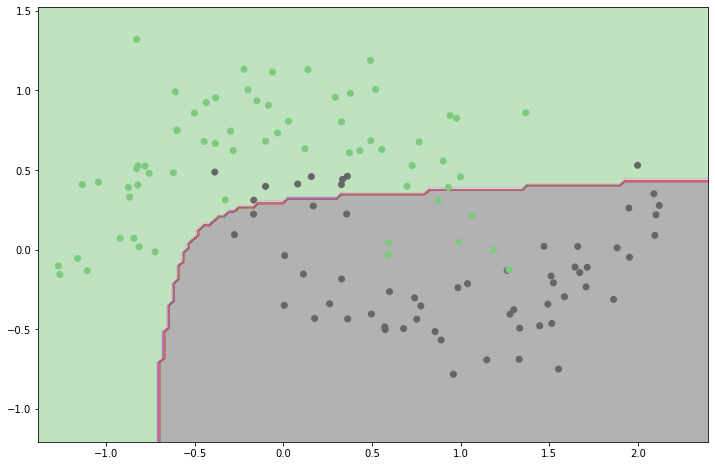

In [21]:
# Plot the decision boundary
# Determine grid range in x and y directions
x_min, x_max = X[:, 0].min()-0.1, X[:, 0].max()+0.1
y_min, y_max = X[:, 1].min()-0.1, X[:, 1].max()+0.1

# Set grid spacing parameter
spacing = min(x_max - x_min, y_max - y_min) / 100

# Create grid
XX, YY = np.meshgrid(np.arange(x_min, x_max, spacing), np.arange(y_min, y_max, spacing))

# Concatenate data to match input
data = np.hstack((XX.ravel().reshape(-1,1), 
                  YY.ravel().reshape(-1,1)))

# Pass data to predict method
data_t = torch.FloatTensor(data)
db_prob = net(data_t)

clf = np.where(db_prob<0.5,0,1)

Z = clf.reshape(XX.shape)

plt.figure(figsize=(12,8))
plt.contourf(XX, YY, Z, cmap=plt.cm.Accent, alpha=0.5)
plt.scatter(X_test[:,0], X_test[:,1], c=y_test, 
            cmap=plt.cm.Accent)
plt.show()

# Improving our Accuracy

In [0]:
class network():

  def __init__(self, X, Y, n_hidden=4, learning_rate=1e-2, device='cpu'):


    self.device = device
    self.X = X
    self.Y = Y.reshape(-1,1)
    self.Y_t = torch.FloatTensor(self.Y).to(device=self.device)
    self.n_input_dim = X.shape[1]
    self.n_output = 1
    self.learning_rate = learning_rate
    self.n_hidden = n_hidden

    # Build network
    self.net = nn.Sequential(
        nn.Linear(self.n_input_dim, self.n_hidden), 
        nn.ELU(),
        nn.Linear(self.n_hidden, self.n_output),
        nn.Sigmoid())
    
    if self.device == 'cuda':
        self.net.cuda()

    self.loss_func = nn.BCELoss()
    self.optimizer = torch.optim.Adam(self.net.parameters(), 
                                      lr=self.learning_rate)
    
    
  def predict(self, X):
    # Function to generate predictions based on data
    X_t = torch.FloatTensor(X).to(device=self.device)
    return self.net(X_t)


  def calculate_loss(self, y_hat):
    return self.loss_func(y_hat, self.Y_t)    

  
  def update_network(self, y_hat):
    self.optimizer.zero_grad()
    loss = self.calculate_loss(y_hat)
    loss.backward()
    self.optimizer.step()
    self.training_loss.append(loss.item())


  def calculate_accuracy(self, y_hat_class, Y):
    return np.sum(Y.reshape(-1,1)==y_hat_class) / len(Y)

  
  def train(self, n_iters=1000):
    self.training_loss = []
    self.training_accuracy = []
    
    for i in range(n_iters):
      y_hat = self.predict(X)
      self.update_network(y_hat)
      y_hat_class = np.where(y_hat<0.5, 0, 1)
      accuracy = self.calculate_accuracy(y_hat_class, self.Y)
      self.training_accuracy.append(accuracy)

  def plot_training_results(self):
    fig, ax = plt.subplots(2, 1, figsize=(12,8))
    ax[0].plot(self.training_loss)
    ax[0].set_ylabel('Loss')
    ax[0].set_title('Training Loss')

    ax[1].plot(self.training_accuracy)
    ax[1].set_ylabel('Classification Accuracy')
    ax[1].set_title('Training Accuracy')

    plt.tight_layout()
    plt.show()
        
  def plot_testing_results(self, X_test, Y_test):
    # Pass test data
    y_hat_test = self.predict(X_test)
    y_hat_test_class = np.where(y_hat_test<0.5, 0, 1)
    print("Test Accuracy {:.2f}%".format(
        self.calculate_accuracy(y_hat_test_class, Y_test) * 100))

    # Plot the decision boundary
    # Determine grid range in x and y directions
    x_min, x_max = X[:, 0].min()-0.1, X[:, 0].max()+0.1
    y_min, y_max = X[:, 1].min()-0.1, X[:, 1].max()+0.1

    # Set grid spacing parameter
    spacing = min(x_max - x_min, y_max - y_min) / 100

    # Create grid
    XX, YY = np.meshgrid(np.arange(x_min, x_max, spacing),
                    np.arange(y_min, y_max, spacing))

    # Concatenate data to match input
    data = np.hstack((XX.ravel().reshape(-1,1), 
                      YY.ravel().reshape(-1,1)))

    # Pass data to predict method
    db_prob = self.predict(data)

    clf = np.where(db_prob<0.5,0,1)

    Z = clf.reshape(XX.shape)

    plt.figure(figsize=(12,8))
    plt.contourf(XX, YY, Z, cmap=plt.cm.inferno, alpha=0.5)
    plt.scatter(X_test[:,0], X_test[:,1], c=Y_test)
    plt.show()

Sequential(
  (0): Linear(in_features=2, out_features=4, bias=True)
  (1): ELU(alpha=1.0)
  (2): Linear(in_features=4, out_features=1, bias=True)
  (3): Sigmoid()
)


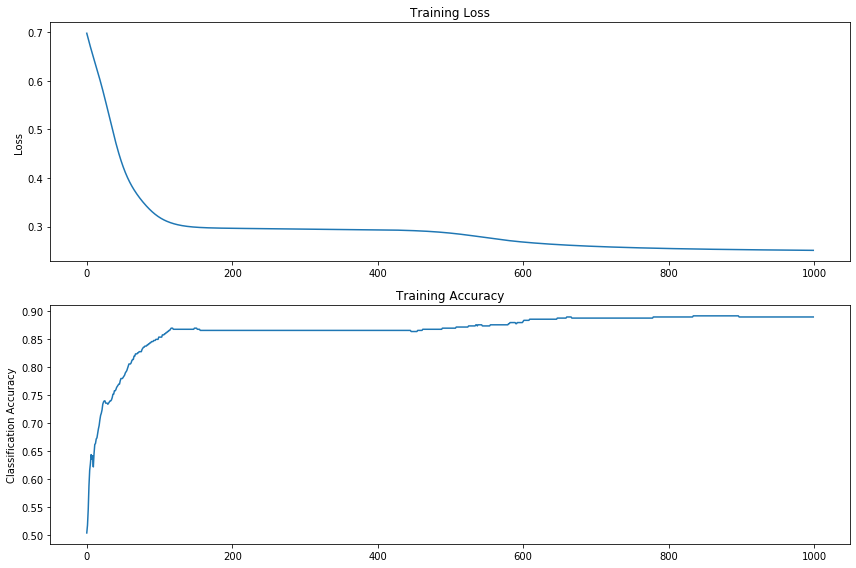

Test Accuracy 87.20%


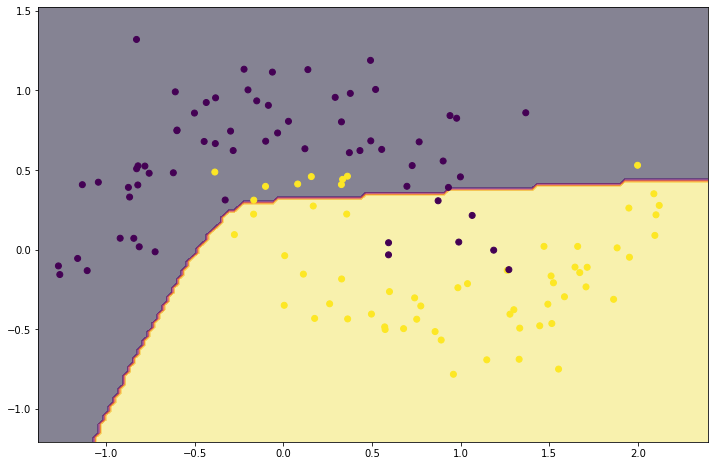

In [26]:
net = network(X, y)
print(net.net)
net.train()
net.plot_training_results()
net.plot_testing_results(X_test, y_test)

 Let’s run this in a loop and see how adjusting the hidden nodes changes our results.

Number of hidden nodes: 1
Test Accuracy 84.80%


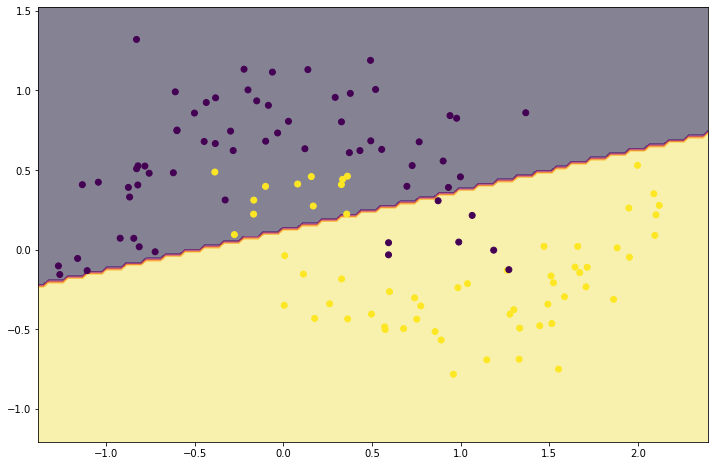

Number of hidden nodes: 5
Test Accuracy 84.80%


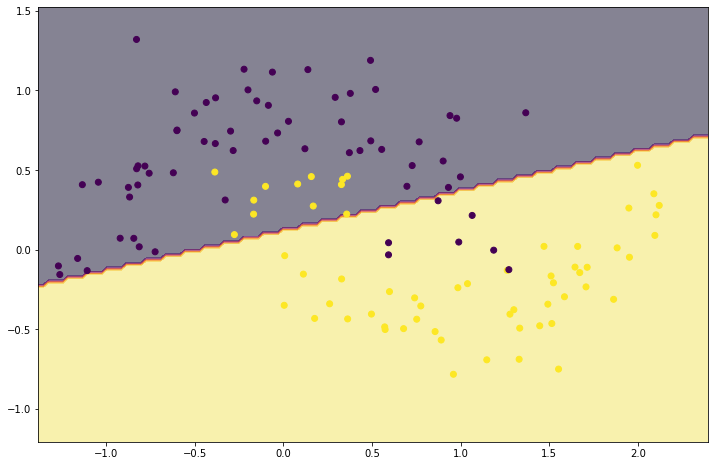

Number of hidden nodes: 10
Test Accuracy 93.60%


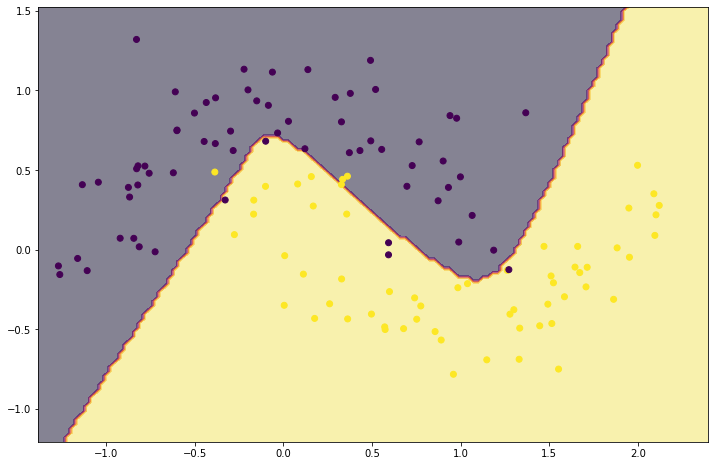

Number of hidden nodes: 25
Test Accuracy 96.00%


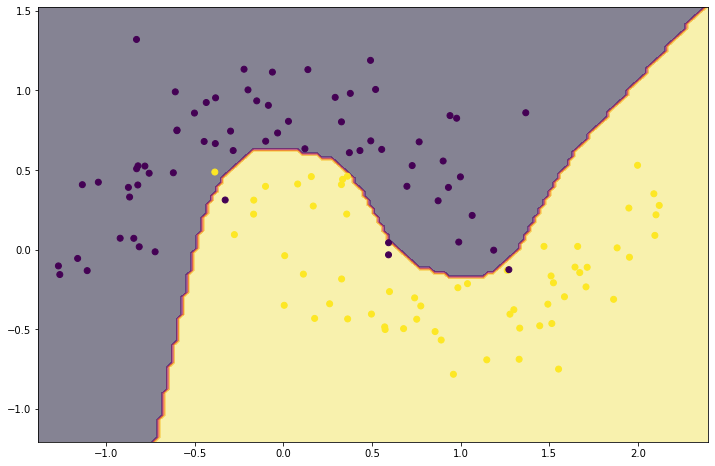

Number of hidden nodes: 50
Test Accuracy 96.00%


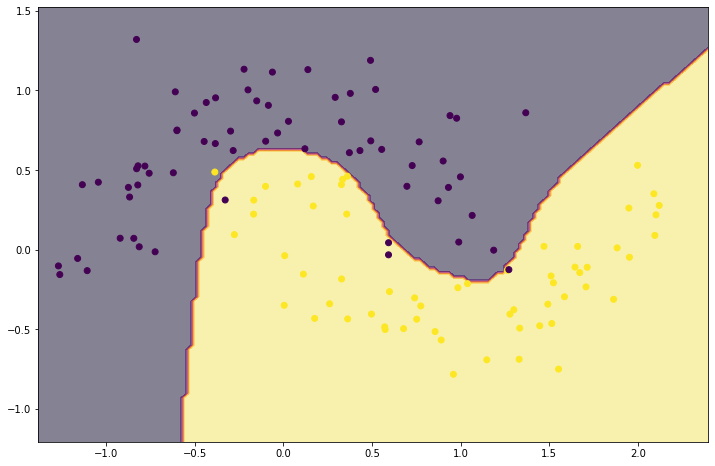

In [30]:
n_hidden_nodes = [1, 5, 10, 25, 50]
for n in n_hidden_nodes:
  print("Number of hidden nodes: {:d}".format(n))
  net = network(X, y, n_hidden=n)
  net.train()
  net.plot_testing_results(X_test, y_test)